Source frame Mass of Neutron Star = $1.35 M_{\odot}$ is known. Redshift = Detector Frame Chirp Mass/Source Frame Chirp Mass -1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import h5py

import matplotlib.pylab as plt
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
import astropy.cosmology as cosmo
import astropy.units as u
import pymc as pm
import scipy.integrate as si

In [5]:
NEVENTS = 10**3

Data Loading

In [6]:
file=h5py.File('Sam.h5','r')
z_med=np.zeros(NEVENTS)
deff_med=np.zeros(NEVENTS)
sigma_z=np.zeros(NEVENTS)
sigma_deff=np.zeros(NEVENTS)

Gpc = 10**3
#3.0857E+25

for i in range(NEVENTS):
    z_med[i]=np.array(file['z_med'+str(i)])
    deff_med[i]=np.array(file['deff_med'+str(i)])/Gpc
    sigma_z[i]=np.array(file['z_sd'+str(i)])
    sigma_deff[i]=np.array(file['deff_sd'+str(i)])/Gpc

No Noise Injection

Text(0, 0.5, '(deff_obs-deff_model)/sigma_deff_obs')

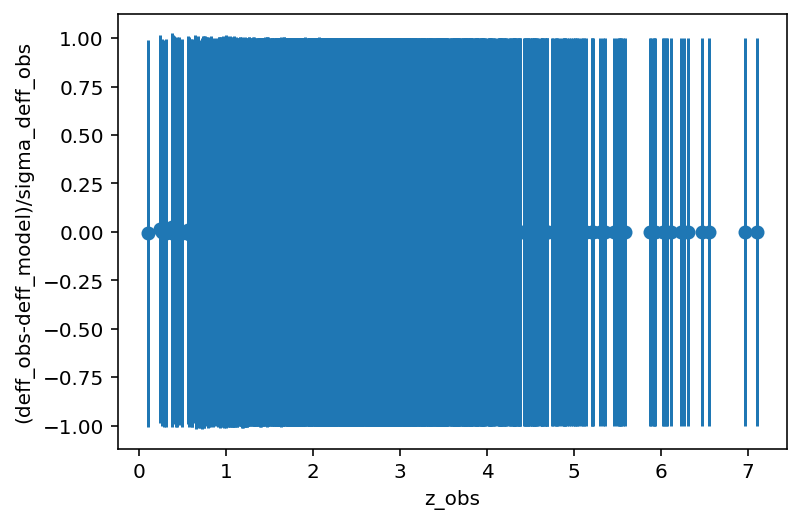

In [15]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# #ax.set_yscale('log')
# ax.errorbar(z_med,deff_med,xerr=sigma_z,yerr=sigma_deff, markersize=1, color = 'green', fmt = 'o', label='Data')
# ax.scatter(z_med, cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc), s=20, color = 'red', label='True')
# plt.xlabel('z')
# plt.ylabel('deff')
# plt.legend()

plt.figure()
plt.errorbar(z_med, (deff_med-cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc).value)/sigma_deff, yerr=np.ones(NEVENTS), fmt='o')
plt.xlabel('z_obs')
plt.ylabel('(deff_obs-deff_model)/sigma_deff_obs')

z error is negligible. $\frac{\Delta D_{eff}}{D_{eff}}$ is within $1-\sigma$. So works fine.

Pymc does not have interpolation module, so it is written.

In [8]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [9]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

Posterior of Cosmological Parameters $\lambda_C = \{H_0, \Omega, w, w_{DM}\}$,

$$
P(\vec{\lambda_C}|\vec{D}) \propto P(\vec{\lambda_C}) \prod_i^{Nobs} L(D_i|\vec{\lambda_C}) = P(\vec{\lambda_C}) \prod_i^{Nobs} N_{DL_{i} ^{obs}}(DL(z_{i}^{obs}, \vec{\lambda_C}), \sigma_{DL}^{obs})
$$

In [10]:
def make_model(zs_obs, sigma_zs_obs, dls_obs, sigma_dls_obs, zmax=100):
    zinterp = plt.expm1(plt.linspace(plt.log(1), plt.log(1+zmax), 1024))

    with pm.Model() as model:
        h = pm.Uniform('h', 0.5, 2, initval=1)
        Om = pm.Uniform('Om', 0, 1, initval=0.3)
        w = pm.Uniform('w', -1.5, -0.5, initval=-1)
        wDM = pm.Uniform('wDM', -0.5, 0.5, initval=0)
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc

        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)

        #z = pm.Uniform('z', 0, zmax, initval=abs(zs_obs), shape=zs_obs.shape[0])
        dL = pm.Deterministic('dL', at_interp(zs_obs, zinterp, dLinterp))

        #pm.Normal('z_likelihood', mu=z, sigma=sigma_zs_obs, observed=zs_obs)
        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_dls_obs, observed=dls_obs)
    return model

In [11]:
with make_model(z_med, sigma_z, deff_med, sigma_deff) as model:
    trace = pm.sample(chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, Om, w, wDM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


In [12]:
with model:
    display(az.summary(trace, var_names=['h', 'Om', 'w', 'wDM']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.700,0.076,0.563,0.842,0.002,0.001,2236.0,1530.0,1.00
Om,0.472,0.279,0.021,0.948,0.006,0.004,2267.0,2246.0,1.00
w,-0.994,0.286,-1.443,-0.510,0.005,0.004,3055.0,2030.0,1.01
wDM,-0.055,0.280,-0.500,0.409,0.005,0.005,2861.0,1540.0,1.00


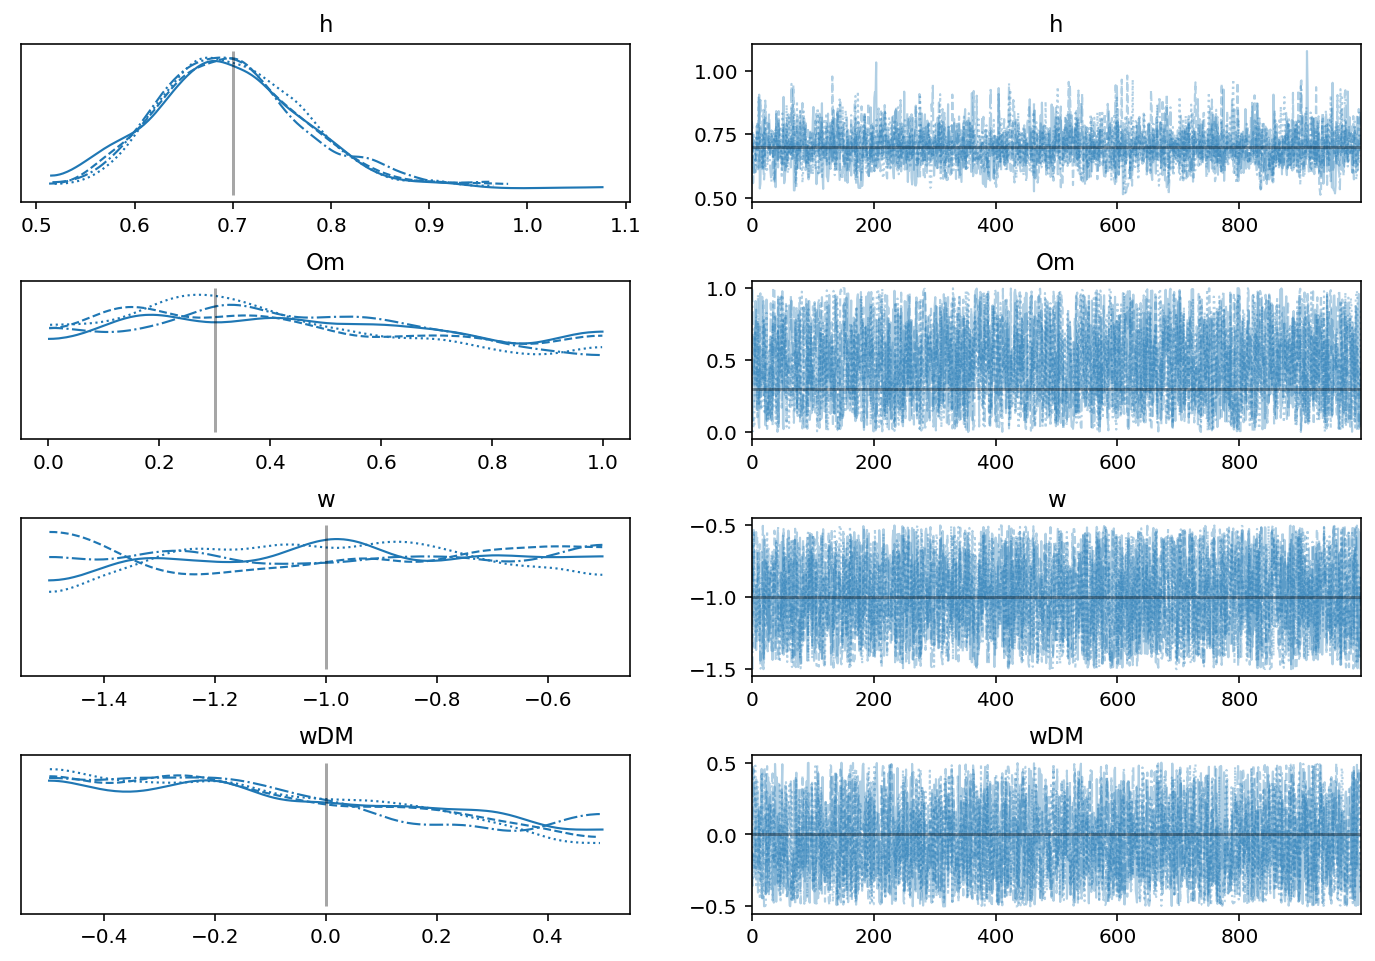

In [13]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'w', 'wDM'],
                  lines=[('h', {}, 0.7),
                        ('Om', {}, 0.3),
                        ('w', {}, -1),
                        ('wDM', {}, 0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

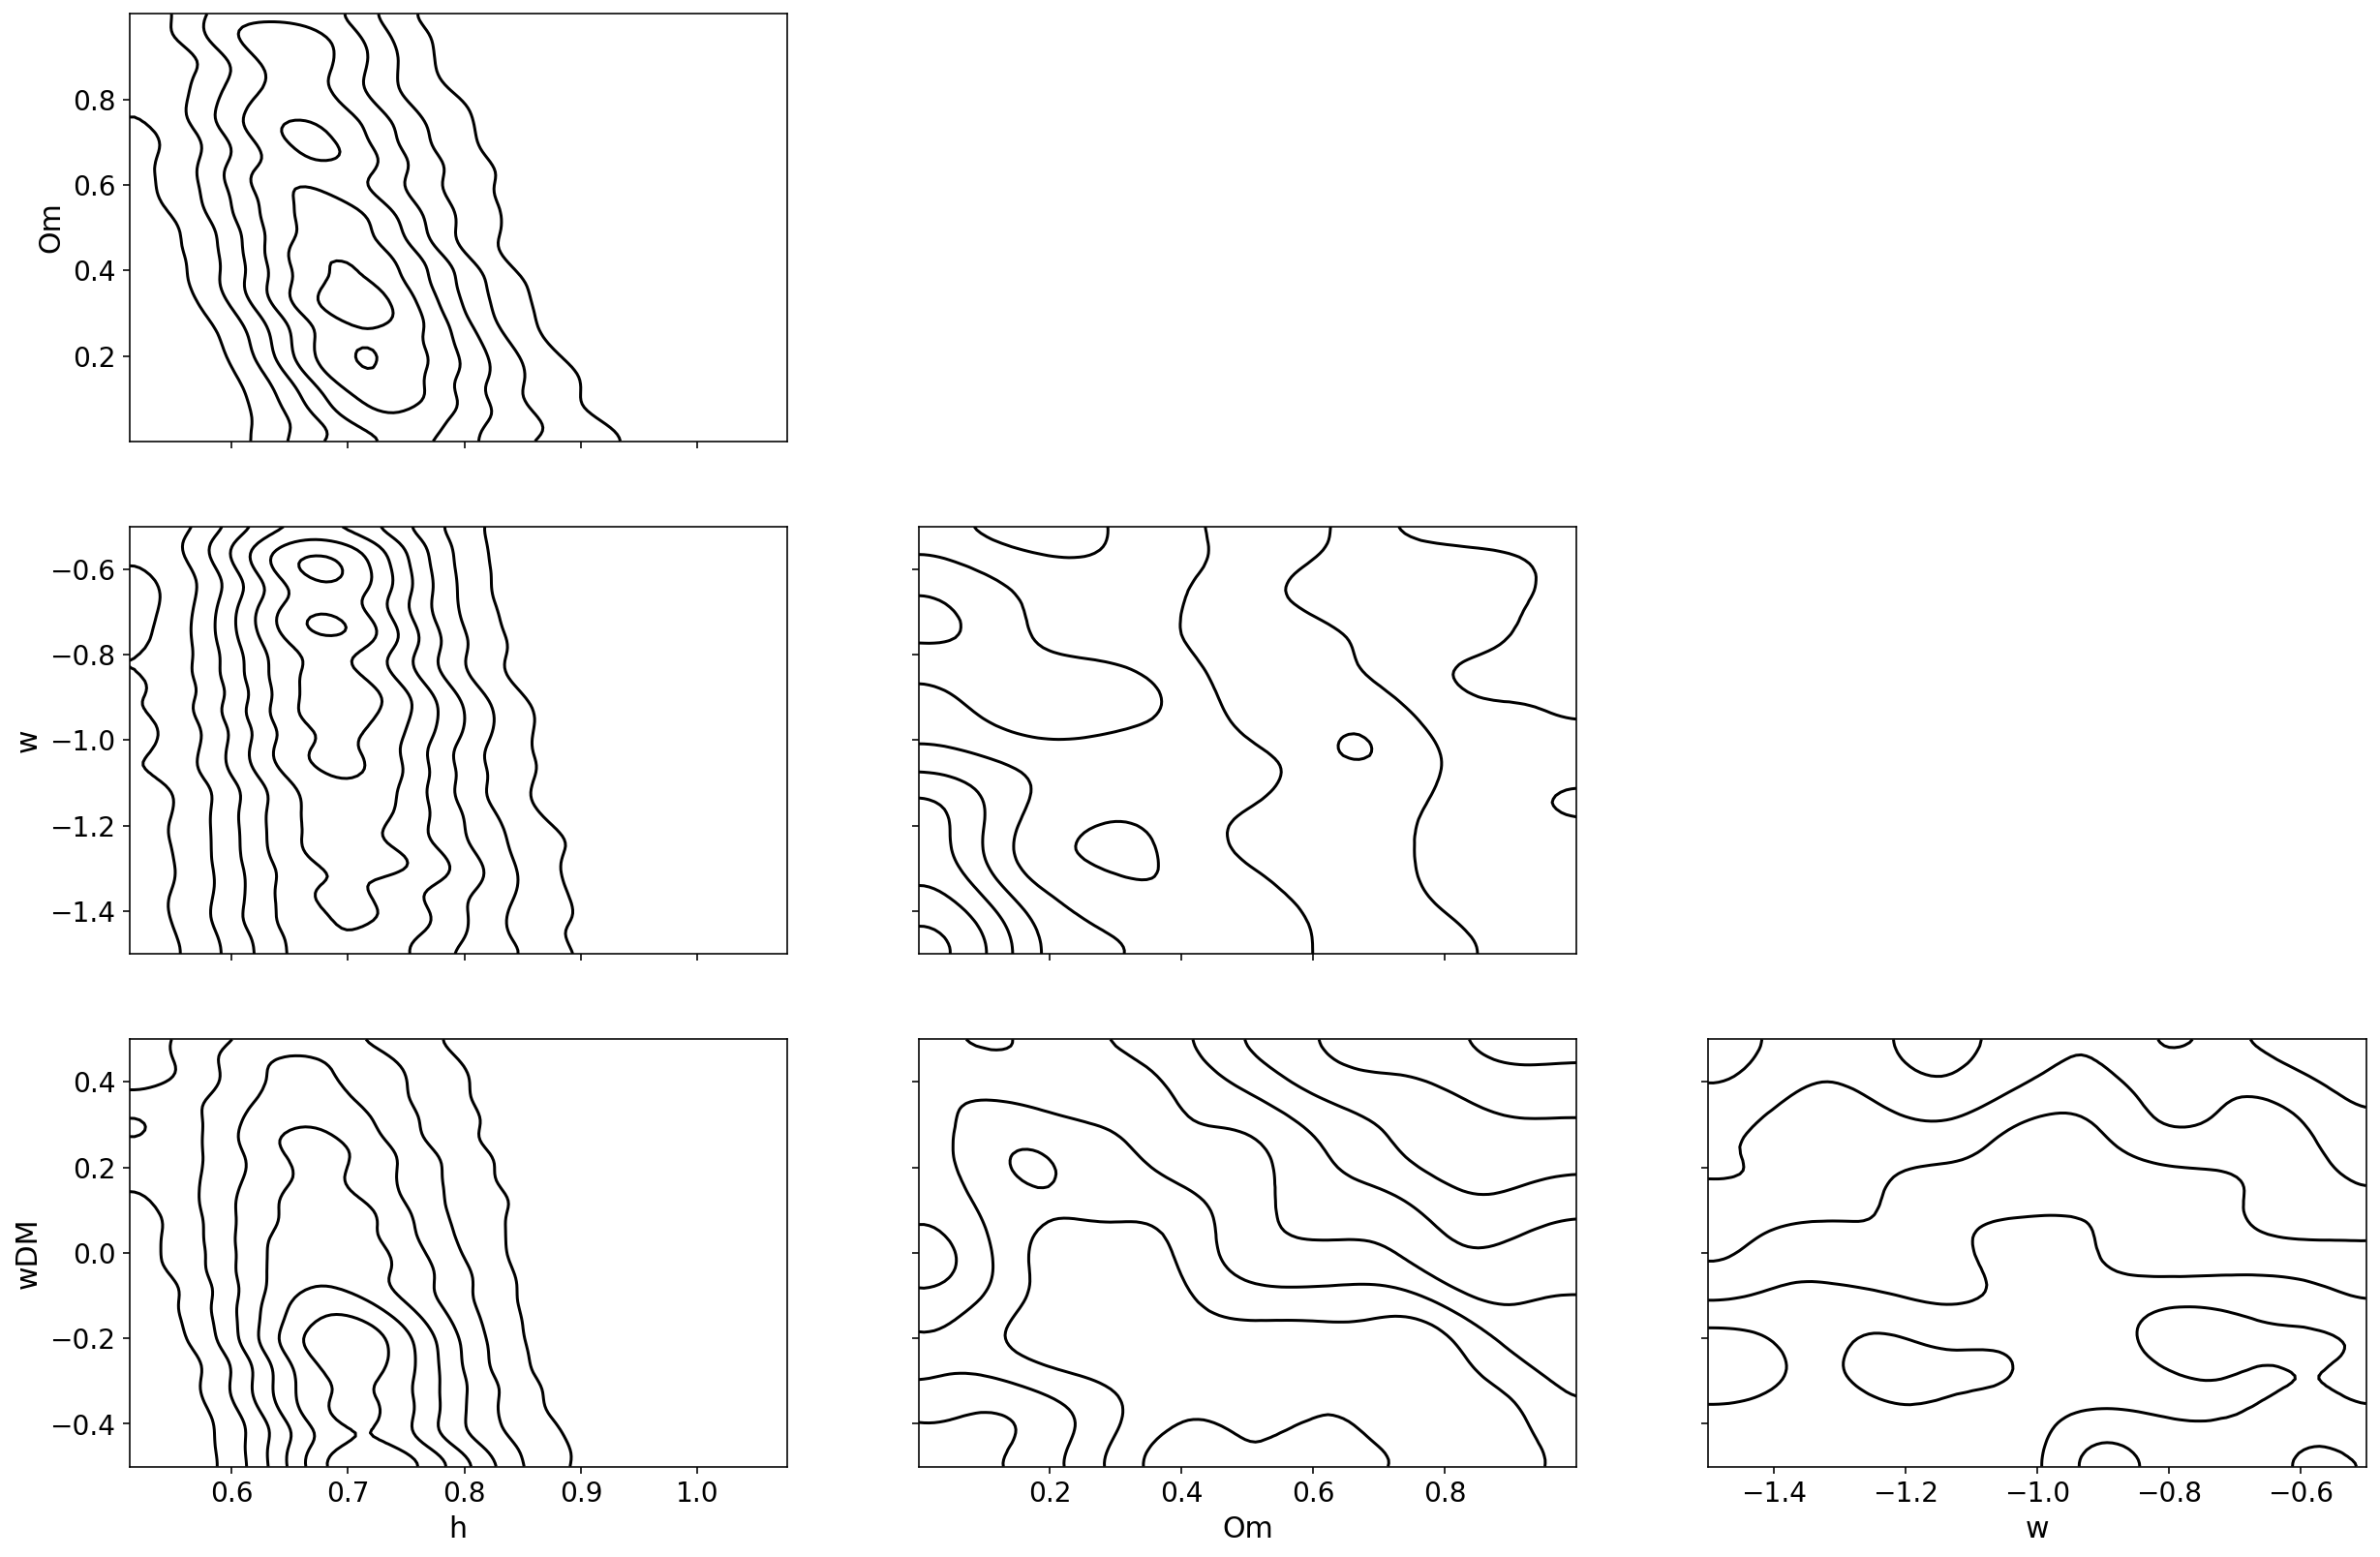

In [14]:
axes = az.plot_pair(trace, var_names=['h', 'Om', 'w', 'wDM'], kind=['kde'], divergences=True)

No noise injection works fine. True value lies within $1-\sigma$ of central tendency measure.

With Noise Injection:

In [16]:
deff_med = deff_med + sigma_deff*np.random.randn(NEVENTS)

Text(0, 0.5, '(deff_obs-deff_model)/sigma_deff_obs')

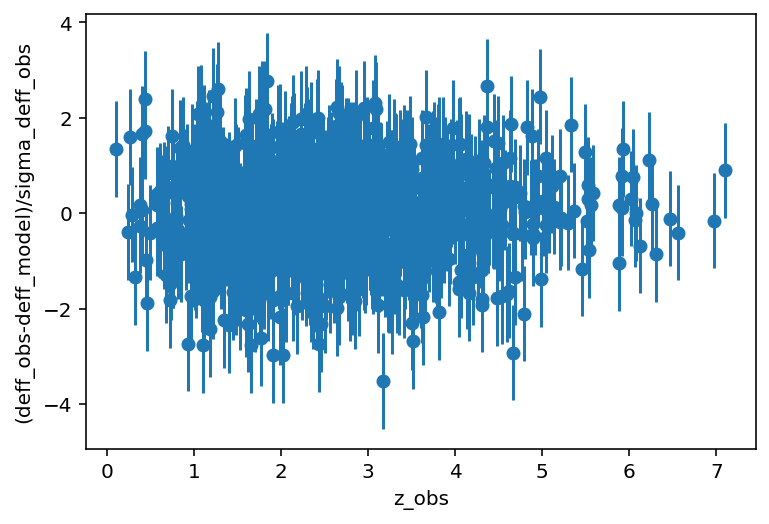

In [18]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# #ax.set_yscale('log')
# ax.errorbar(z_med,deff_med,xerr=sigma_z,yerr=sigma_deff, markersize=1, color = 'green', fmt = 'o', label='Data')
# ax.scatter(z_med, cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc), s=20, color = 'red', label='True')
# plt.xlabel('z')
# plt.ylabel('deff')
# plt.legend()

plt.figure()
plt.errorbar(z_med, (deff_med-cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc).value)/sigma_deff, yerr=np.ones(NEVENTS), fmt='o')
plt.xlabel('z_obs')
plt.ylabel('(deff_obs-deff_model)/sigma_deff_obs')

z error is again negligible. $\Delta d_{eff}/d_{eff}$ is within $4-\sigma$ with mean 0. Let's proceed.

Cosmological Parameter Estimation by Pymc

In [19]:
with make_model(z_med, sigma_z, deff_med, sigma_deff) as model:
    trace = pm.sample(chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, Om, w, wDM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [20]:
with model:
    display(az.summary(trace, var_names=['h', 'Om', 'w', 'wDM']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.621,0.062,0.505,0.725,0.001,0.001,2009.0,1291.0,1.0
Om,0.649,0.241,0.224,1.000,0.005,0.004,1844.0,1638.0,1.0
w,-0.975,0.292,-1.437,-0.501,0.005,0.004,2981.0,2054.0,1.0
wDM,0.147,0.253,-0.323,0.500,0.005,0.004,2373.0,1783.0,1.0


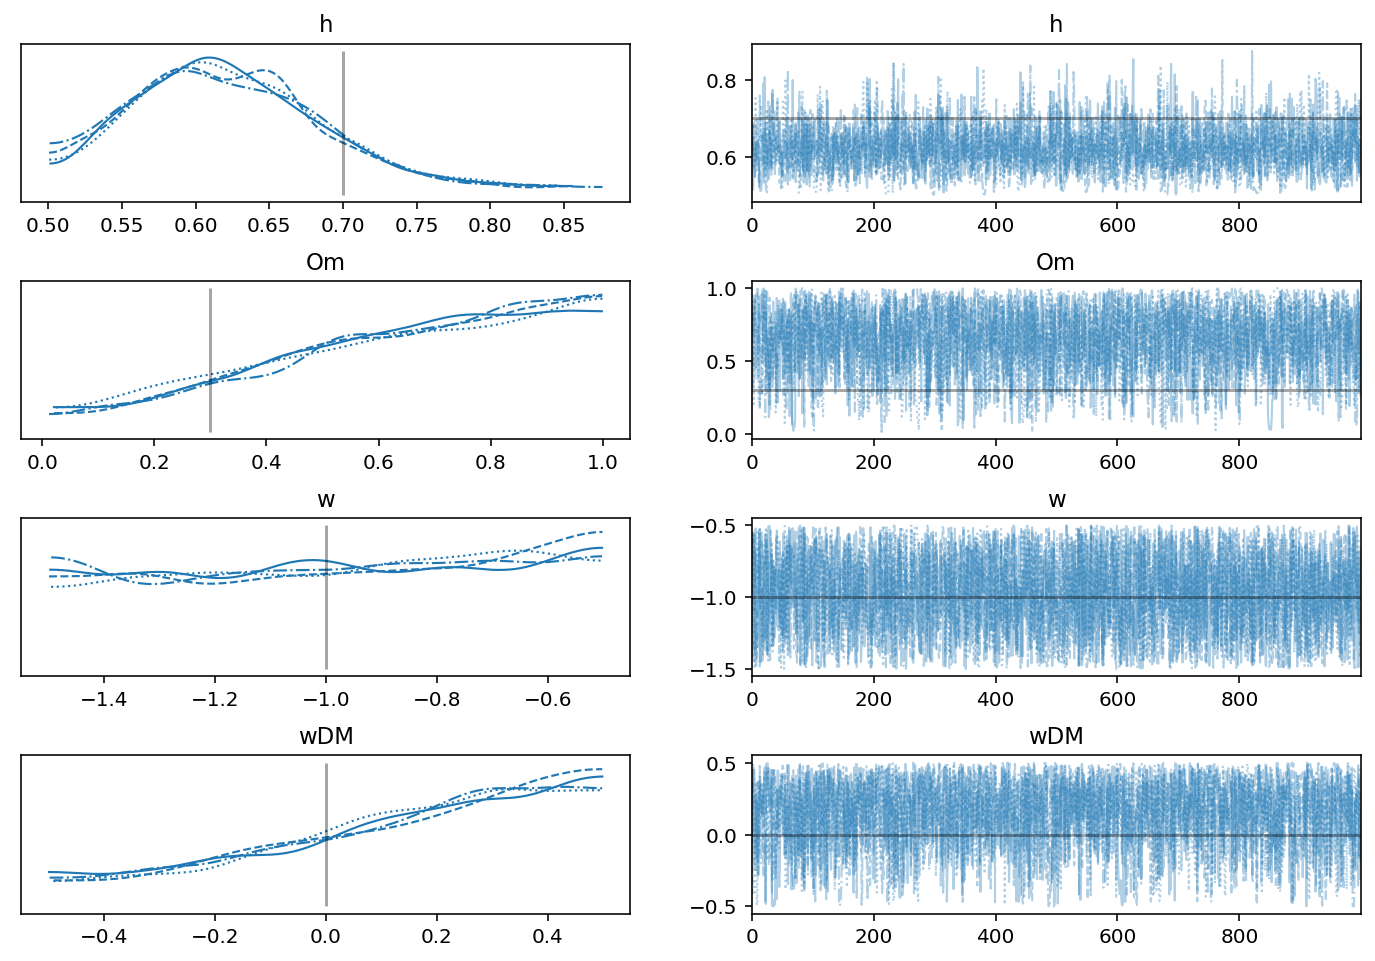

In [21]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'w', 'wDM'],
                  lines=[('h', {}, 0.7),
                        ('Om', {}, 0.3),
                        ('w', {}, -1),
                        ('wDM', {}, 0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

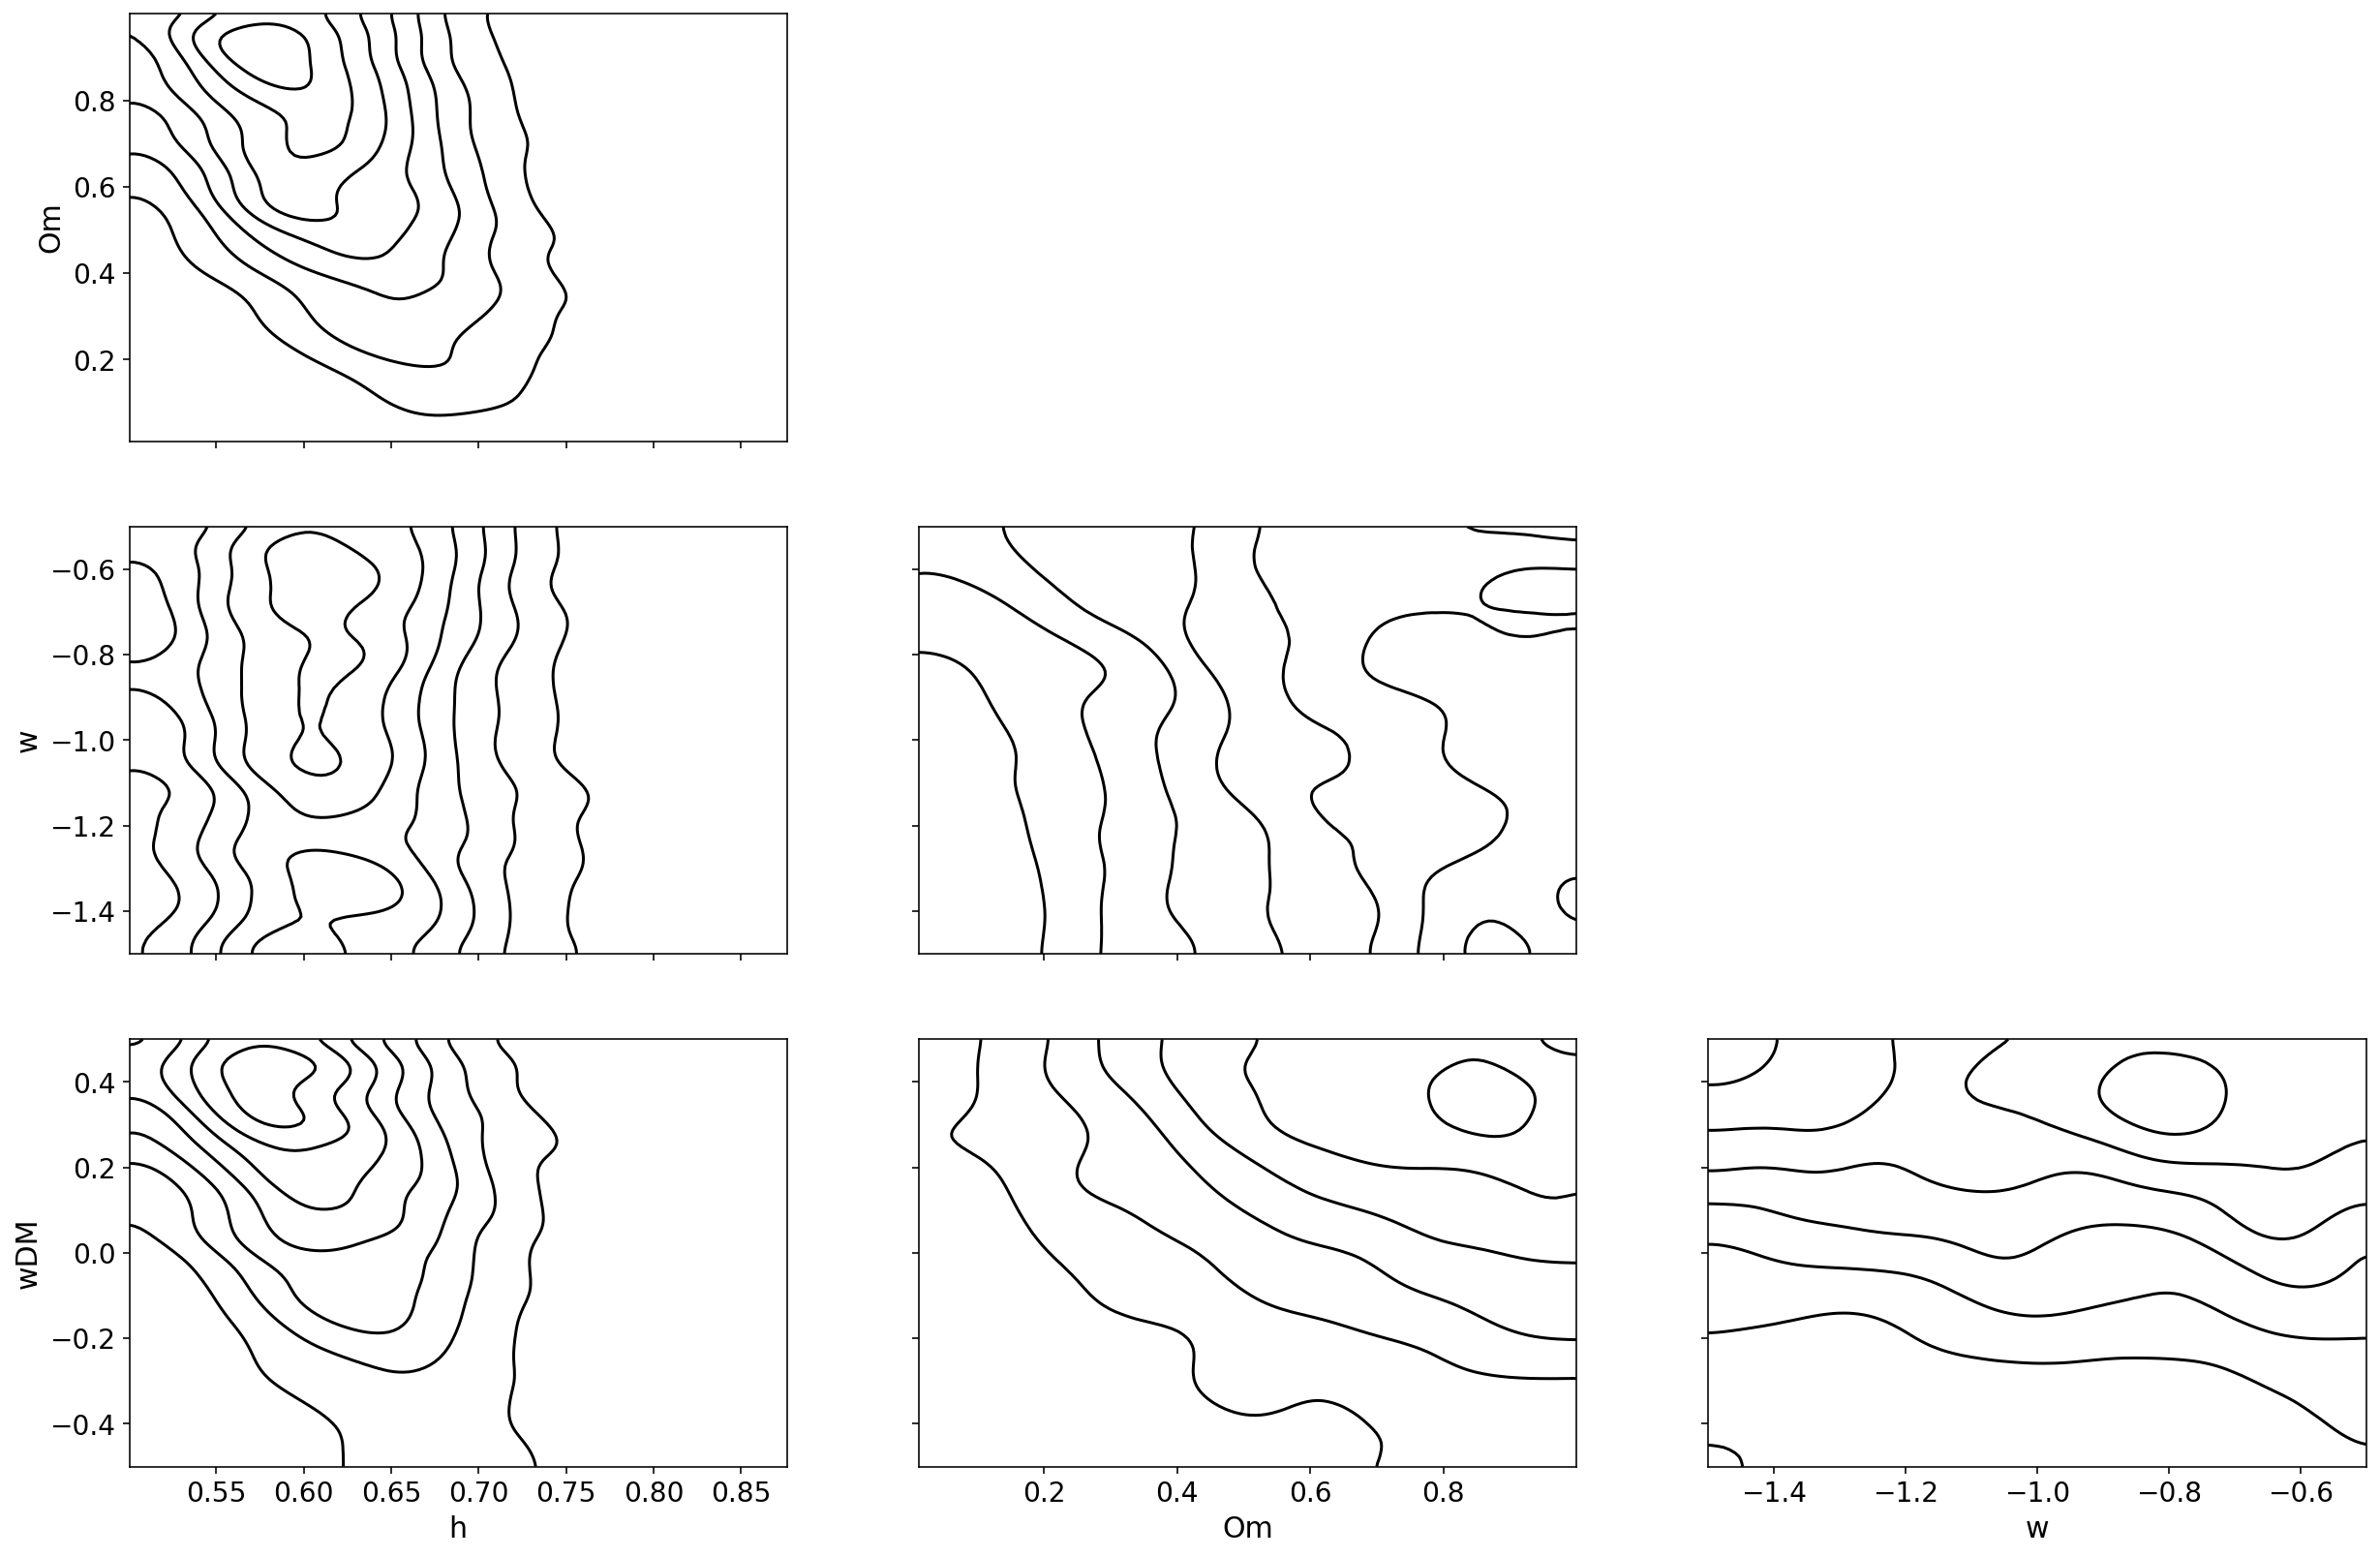

In [22]:
axes = az.plot_pair(trace, var_names=['h', 'Om', 'w', 'wDM'], kind=['kde'], divergences=True)